# Argo Density Sections

In this notebook, I'll move from the argo_sections framework (where everything was plotted in depth coordinates) to using density as the vertical coordinate. I'm hoping this is already largely possible within the functions I've written. The first step is to save ds_rho versions for each section (from the methods in argo_box_loader) and then used to make the plots in argo_sections.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw

import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf

In [37]:
reload(df)
reload(ef)
reload(ff)

<module 'filt_funcs' from '/home/amf2288/argo-intern/filt_funcs.py'>

In [3]:
watl = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-60,-55)_lat:(10,45)_ds_z.nc')

In [4]:
watl = prf.get_MLD(watl)

In [7]:
lfilter = 75
lat_bins = np.arange(10,50,2)
SPICE_anom_binned = watl.SPICE.groupby_bins('LATITUDE',lat_bins) - watl.SPICE.groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
watl = watl.assign(SPICE_anom_binned=(['N_PROF','PRES_INTERPOLATED'],SPICE_anom_binned.data))
watl_SPICE_anom_binned_EKE = ef.get_EV(watl,lfilter,variable='SPICE_anom_binned')

In [204]:
lat_bins = np.arange(10,50,2)

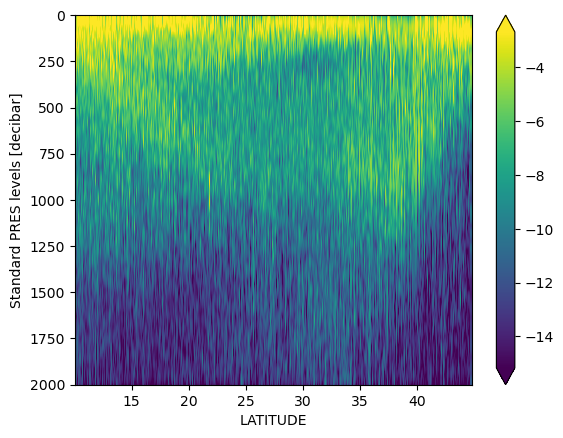

In [12]:
np.log(watl_SPICE_anom_binned_EKE).sortby('LATITUDE').plot(x='LATITUDE',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

In [14]:
watl = watl.assign(SPICE_anom_binned_EV75=(['N_PROF','PRES_INTERPOLATED'],watl_SPICE_anom_binned_EKE.data))
watl

<xarray.Dataset>
Dimensions:                 (N_PROF: 3241, PRES_INTERPOLATED: 1001)
Coordinates:
  * N_PROF                  (N_PROF) int64 1670 1676 2597 ... 10433 789 10552
    TIME                    (N_PROF) datetime64[ns] 2001-11-21T06:57:00.00000...
    LATITUDE                (N_PROF) float64 43.49 42.95 35.9 ... 22.97 11.08
    LONGITUDE               (N_PROF) float64 -57.67 -57.26 ... -59.38 -56.98
  * PRES_INTERPOLATED       (PRES_INTERPOLATED) int64 0 2 4 6 ... 1996 1998 2000
    MLD                     (N_PROF) int64 10 28 68 86 70 130 ... 8 8 0 8 6 14
Data variables: (12/14)
    CT                      (N_PROF, PRES_INTERPOLATED) float64 ...
    CYCLE_NUMBER            (N_PROF) int64 ...
    DATA_MODE               (N_PROF) object ...
    DIRECTION               (N_PROF) object ...
    PLATFORM_NUMBER         (N_PROF) int64 ...
    PRES                    (N_PROF, PRES_INTERPOLATED) float32 ...
    ...                      ...
    SIG0                    (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP                    (N_PROF, PRES_INTERPOLATED) float32 ...
    sample_rate             (N_PROF, PRES_INTERPOLATED) float32 ...
    SPICE                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SPICE_anom_binned       (N_PROF, PRES_INTERPOLATED) float64 -0.6702 ... 0...
    SPICE_anom_binned_EV75  (N_PROF, PRES_INTERPOLATED) float64 0.03059 ... 2...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2024/02/15
    Fetched_constraints:  [x=-60.00/-55.00; y=10.00/45.00; z=0.0/2001.0]
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...

### Load Sections in Density Space

In [43]:
print('max: {}, min: {}'.format(watl.SIG0.max().values, watl.SIG0.min().values))

max: 27.88255734319887, min: 17.501254662576912


In [44]:
watl_grid = np.linspace(17.5,28,1000)

In [47]:
number=np.arange(0,len(watl.N_PROF))
watl.sortby('LATITUDE')
watl.coords['N_PROF_NEW']=xr.DataArray(number,dims=watl.N_PROF.dims)

In [48]:
rho_watl= df.interpolate2density_prof(watl, watl_grid)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


In [49]:
rho_watl

<xarray.Dataset>
Dimensions:                 (rho_grid: 1000, N_PROF_NEW: 3241)
Coordinates:
  * rho_grid                (rho_grid) float64 17.5 17.51 17.52 ... 27.99 28.0
  * N_PROF_NEW              (N_PROF_NEW) int64 0 1 2 3 4 ... 3237 3238 3239 3240
    TIME                    (N_PROF_NEW) datetime64[ns] 2001-11-21T06:57:00.0...
    LATITUDE                (N_PROF_NEW) float64 43.49 42.95 ... 22.97 11.08
    LONGITUDE               (N_PROF_NEW) float64 -57.67 -57.26 ... -59.38 -56.98
    MLD                     (N_PROF_NEW) int64 10 28 68 86 70 130 ... 8 0 8 6 14
Data variables:
    PRES                    (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    CT                      (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SA                      (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SIG0                    (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SPICE                   (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SPICE_anom_binned_EV75  (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan

In [51]:
rho_watl.to_netcdf('/swot/SUM05/amf2288/sync-boxes/lon:(-60,-55)_lat:(10,45)_ds_rho_test.nc')

## Plotting Tracers

In [52]:
x = 'LATITUDE'

In [53]:
levels = [26.3,27,27.6,27.75]

Text(0.5, 1.0, 'Spice')

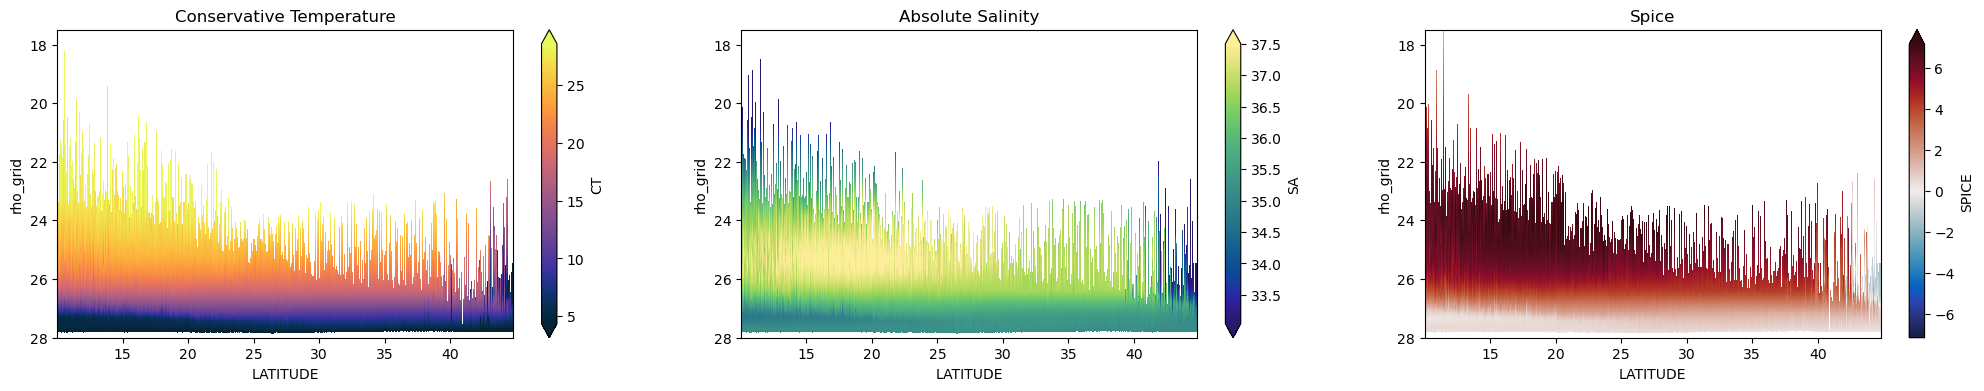

In [59]:
#GOAL: plotting CT, SA, SPICE in density space
plt.figure(figsize=(25,4))

plt.subplot(131)
rho_watl.CT.sortby(x).plot(x=x,y='rho_grid',cmap=cmo.thermal,robust=True)
plt.gca().invert_yaxis()
plt.title('Conservative Temperature')

plt.subplot(132)
rho_watl.SA.sortby(x).plot(x=x,y='rho_grid',cmap=cmo.haline,robust=True)
plt.gca().invert_yaxis()
plt.title('Absolute Salinity')

plt.subplot(133)
rho_watl.SPICE.sortby(x).plot(x=x,y='rho_grid',cmap=cmo.balance,robust=True)
plt.gca().invert_yaxis()
plt.title('Spice')

Check distributiuon of density points compared to depth

(27.8, 26.25)

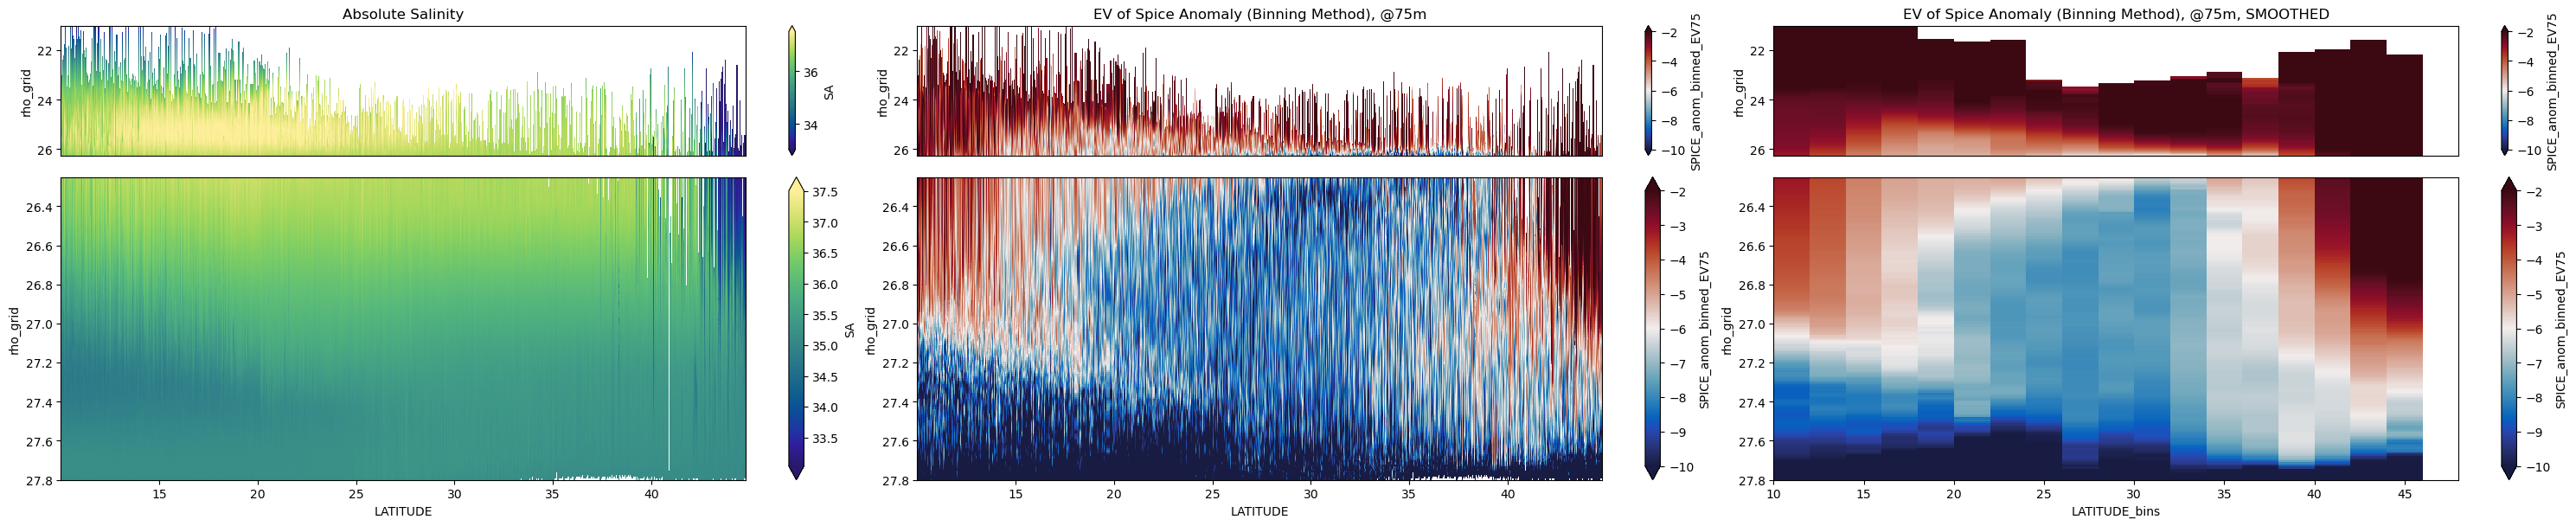

In [118]:
#GOAL: want to adjust the skew of vertical coordinate so it better represents the division of densities across depth 
#      (this was completely incomprehensible, but picture WOCE sections)
fig = plt.figure(figsize=(30,5))
top = 21
mid = 26.25
bot = 27.8

ax1 = fig.add_axes([0,0.75,0.33,0.3])
rho_watl.SA.sortby(x).plot(x=x,y='rho_grid',ax=ax1,cmap=cmo.haline,robust=True)
plt.gca().invert_yaxis()
ax1.set_ylim(mid,top)
ax1.set_xticks([])
ax1.set_xlabel('')
plt.title('Absolute Salinity')

ax2 = fig.add_axes([0,0,0.33,0.7])
rho_watl.SA.sortby(x).plot(x=x,y='rho_grid',ax=ax2,cmap=cmo.haline,robust=True)
plt.gca().invert_yaxis()
ax2.set_ylim(bot,mid)

ax3 = fig.add_axes([0.33,0.75,0.33,0.3])
np.log(rho_watl.SPICE_anom_binned_EV75).sortby(x).plot(x=x,y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax3.set_ylim(mid,top)
ax3.set_xticks([])
ax3.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m'.format(lfilter))

ax4 = fig.add_axes([0.33,0,0.33,0.7])
np.log(rho_watl.SPICE_anom_binned_EV75).sortby(x).plot(x=x,y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax4.set_ylim(bot,mid)

ax5 = fig.add_axes([0.66,0.75,0.33,0.3])
np.log(rho_watl.SPICE_anom_binned_EV75.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax5,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax5.set_ylim(mid,top)
ax5.set_xticks([])
ax5.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, SMOOTHED'.format(lfilter))

ax6 = fig.add_axes([0.66,0,0.33,0.7])
np.log(rho_watl.SPICE_anom_binned_EV75.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax6,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax6.set_ylim(bot,mid)

In [194]:
rho_watl_wint = rho_watl.SPICE_anom_binned_EV75.where(rho_watl.TIME.dt.month <4).dropna(dim='N_PROF_NEW',how='all')
rho_watl_summ = rho_watl.SPICE_anom_binned_EV75.where(rho_watl.TIME.dt.month <10).where(rho_watl.TIME.dt.month >6).dropna(dim='N_PROF_NEW',how='all')
print('winter months: {}, summer months: {}'.format(np.unique(rho_watl_wint.TIME.dt.month.data),np.unique(rho_watl_summ.TIME.dt.month.data)))

winter months: [1 2 3], summer months: [7 8 9]


(27.8, 26.25)

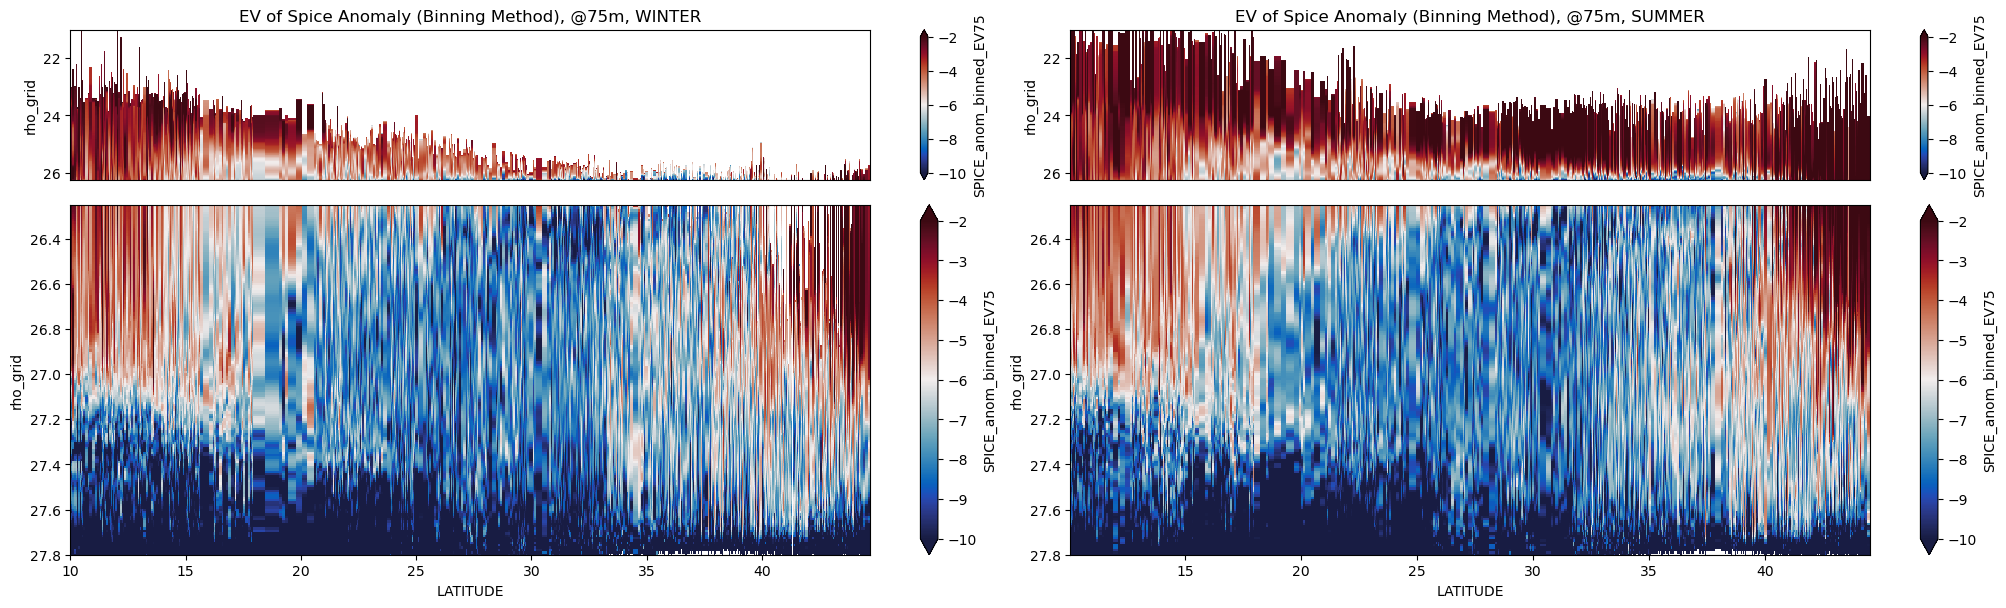

In [206]:
fig = plt.figure(figsize=(20,5))

top = 21
mid = 26.25
bot = 27.8

ax1 = fig.add_axes([0,0.75,0.5,0.3])
np.log(rho_watl_wint.sortby(x)).plot(x=x,y='rho_grid',ax=ax1,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax1.set_ylim(mid,top)
ax1.set_xticks([])
ax1.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, WINTER'.format(lfilter))

ax2 = fig.add_axes([0,0,0.5,0.7])
np.log(rho_watl_wint.sortby(x)).plot(x=x,y='rho_grid',ax=ax2,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax2.set_ylim(bot,mid)

ax3 = fig.add_axes([0.5,0.75,0.5,0.3])
np.log(rho_watl_summ.sortby(x)).plot(x=x,y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax3.set_ylim(mid,top)
ax3.set_xticks([])
ax3.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, SUMMER'.format(lfilter))

ax4 = fig.add_axes([0.5,0,0.5,0.7])
np.log(rho_watl_summ.sortby(x)).plot(x=x,y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax4.set_ylim(bot,mid)

(27.8, 26.25)

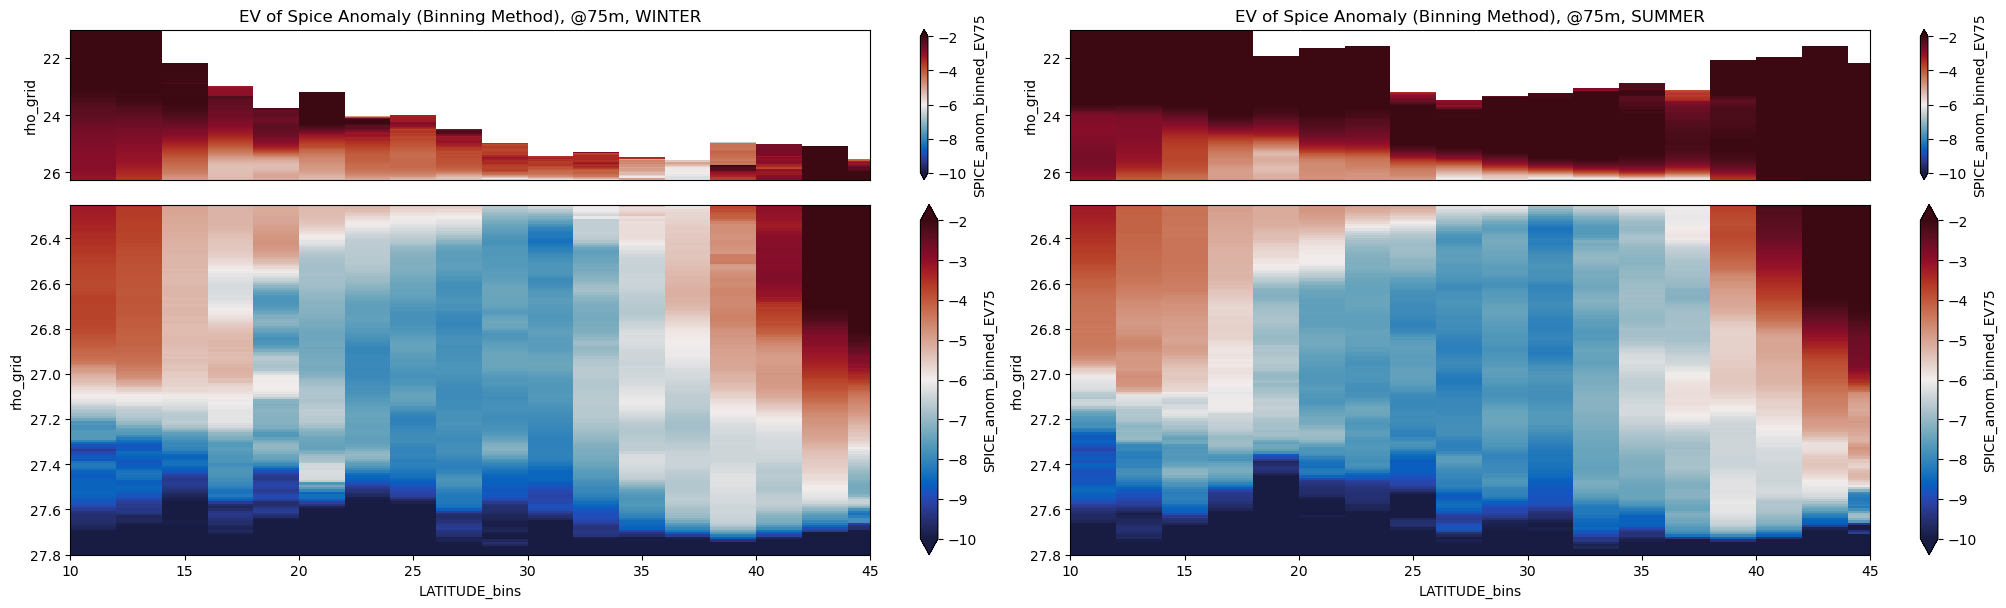

In [232]:
fig = plt.figure(figsize=(20,5))

top = 21
mid = 26.25
bot = 27.8

ax1 = fig.add_axes([0,0.75,0.5,0.3])
np.log(rho_watl_wint.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax1,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax1.set_ylim(mid,top)
ax1.set_xlim(10,45)
ax1.set_xticks([])
ax1.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, WINTER'.format(lfilter))

ax2 = fig.add_axes([0,0,0.5,0.7])
np.log(rho_watl_wint.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax2,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax2.set_xlim(10,45)
ax2.set_ylim(bot,mid)

ax3 = fig.add_axes([0.5,0.75,0.5,0.3])
np.log(rho_watl_summ.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax3.set_ylim(mid,top)
ax3.set_xlim(10,45)
ax3.set_xticks([])
ax3.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, SUMMER'.format(lfilter))

ax4 = fig.add_axes([0.5,0,0.5,0.7])
np.log(rho_watl_summ.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax4.set_xlim(10,45)
ax4.set_ylim(bot,mid)

### Thoughts

This is super exciting!! First time we have plots of EV where density is the vertical coordinate. On quick glance it seems much easier to tell where the mode water is, I don't think I know enough of what I'm looking for to comment on signitures of ventillation --- but all this to say, pretty cool plots. Also (as you can tell) I've made them look a bit more "proportional" to how things would be spaced in depth by separating into the surface (with large density change) and depth (where density changes less rapidly).

This is definitely not to say this method is ready for global quantification though. A few things come to mind that must be addressed:
- First, the binning method. If I remember correctly, I was having significant touble getting `groupby_bins()` to work on both latitude and longitude. Making sure this works is essential to mapping anything.
- It would be ideal to fold this method into a function instead of copying/pasting everything each time. This will require making sure the binning parameters can be set with keywords.
- It takes an annoyingly long time to run this. Is it possible to speed this up somehow? I fear this will require tinkering with the functions for converting to density space, which I don't understand particularly well.
- For sorting into winter and summer, this obviously changes with hemisphere. For sections that extend into each hemisphere, think through how to go about this.

In [127]:
atl = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-25,-20)_lat:(-70,70)_ds_z.nc')

In [128]:
atl = prf.get_MLD(atl)

In [129]:
lfilter = 75
lat_bins = np.arange(-70,70,2)
SPICE_anom_binned = atl.SPICE.groupby_bins('LATITUDE',lat_bins) - atl.SPICE.groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
atl = atl.assign(SPICE_anom_binned=(['N_PROF','PRES_INTERPOLATED'],SPICE_anom_binned.data))
atl_SPICE_anom_binned_EKE = ef.get_EV(atl,lfilter,variable='SPICE_anom_binned')

In [131]:
atl = atl.assign(SPICE_anom_binned_EV75=(['N_PROF','PRES_INTERPOLATED'],atl_SPICE_anom_binned_EKE.data))
atl

<xarray.Dataset>
Dimensions:                 (N_PROF: 10970, PRES_INTERPOLATED: 500)
Coordinates:
  * N_PROF                  (N_PROF) int64 1446 1429 1448 ... 24199 23313 23841
    TIME                    (N_PROF) datetime64[ns] 2000-12-27T05:50:00 ... 2...
    LATITUDE                (N_PROF) float64 -5.839 -8.064 ... 39.81 -17.82
    LONGITUDE               (N_PROF) float64 -23.33 -21.05 ... -24.35 -21.94
  * PRES_INTERPOLATED       (PRES_INTERPOLATED) int64 0 4 8 ... 1988 1992 1996
    MLD                     (N_PROF) int64 64 4 16 72 64 12 ... 24 20 4 8 12 148
    month                   (N_PROF) int64 ...
    month_frac              (N_PROF) float64 ...
    year                    (N_PROF) int64 ...
    year_frac               (N_PROF) float64 ...
Data variables: (12/14)
    CT                      (N_PROF, PRES_INTERPOLATED) float64 ...
    CYCLE_NUMBER            (N_PROF) int64 ...
    DATA_MODE               (N_PROF) object ...
    DIRECTION               (N_PROF) object ...
    PLATFORM_NUMBER         (N_PROF) int64 ...
    PRES                    (N_PROF, PRES_INTERPOLATED) float32 ...
    ...                      ...
    SIG0                    (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP                    (N_PROF, PRES_INTERPOLATED) float32 ...
    sample_rate             (N_PROF, PRES_INTERPOLATED) float32 ...
    SPICE                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SPICE_anom_binned       (N_PROF, PRES_INTERPOLATED) float64 -0.3356 ... 0...
    SPICE_anom_binned_EV75  (N_PROF, PRES_INTERPOLATED) float64 0.0003578 ......
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2024/02/15
    Fetched_constraints:  [x=-25.00/-20.00; y=-70.00/70.00; z=0.0/2000.0]
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...

In [132]:
print('max: {}, min: {}'.format(atl.SIG0.max().values, atl.SIG0.min().values))

max: 27.914478646952148, min: 21.12826481587217


In [133]:
atl_grid = np.linspace(21,28,1000)

In [134]:
number=np.arange(0,len(atl.N_PROF))
atl.sortby('LATITUDE')
atl.coords['N_PROF_NEW']=xr.DataArray(number,dims=atl.N_PROF.dims)

In [135]:
rho_atl= df.interpolate2density_prof(atl, atl_grid)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900


In [136]:
rho_atl

<xarray.Dataset>
Dimensions:                 (rho_grid: 1000, N_PROF_NEW: 10970)
Coordinates:
  * rho_grid                (rho_grid) float64 21.0 21.01 21.01 ... 27.99 28.0
  * N_PROF_NEW              (N_PROF_NEW) int64 0 1 2 3 ... 10967 10968 10969
    TIME                    (N_PROF_NEW) datetime64[ns] 2000-12-27T05:50:00 ....
    LATITUDE                (N_PROF_NEW) float64 -5.839 -8.064 ... 39.81 -17.82
    LONGITUDE               (N_PROF_NEW) float64 -23.33 -21.05 ... -24.35 -21.94
    MLD                     (N_PROF_NEW) int64 64 4 16 72 64 ... 20 4 8 12 148
Data variables:
    PRES                    (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    CT                      (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SA                      (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SIG0                    (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SPICE                   (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan
    SPICE_anom_binned_EV75  (rho_grid, N_PROF_NEW) float64 nan nan ... nan nan

In [137]:
rho_atl.to_netcdf('/swot/SUM05/amf2288/sync-boxes/lon:(-25,-20)_lat:(-70,70)_ds_rho_test.nc')

In [200]:
print('max: {}, min: {}'.format(atl.SIG0.max().values, atl.SIG0.min().values))

max: 27.914478646952148, min: 21.12826481587217


(27.8, 26.25)

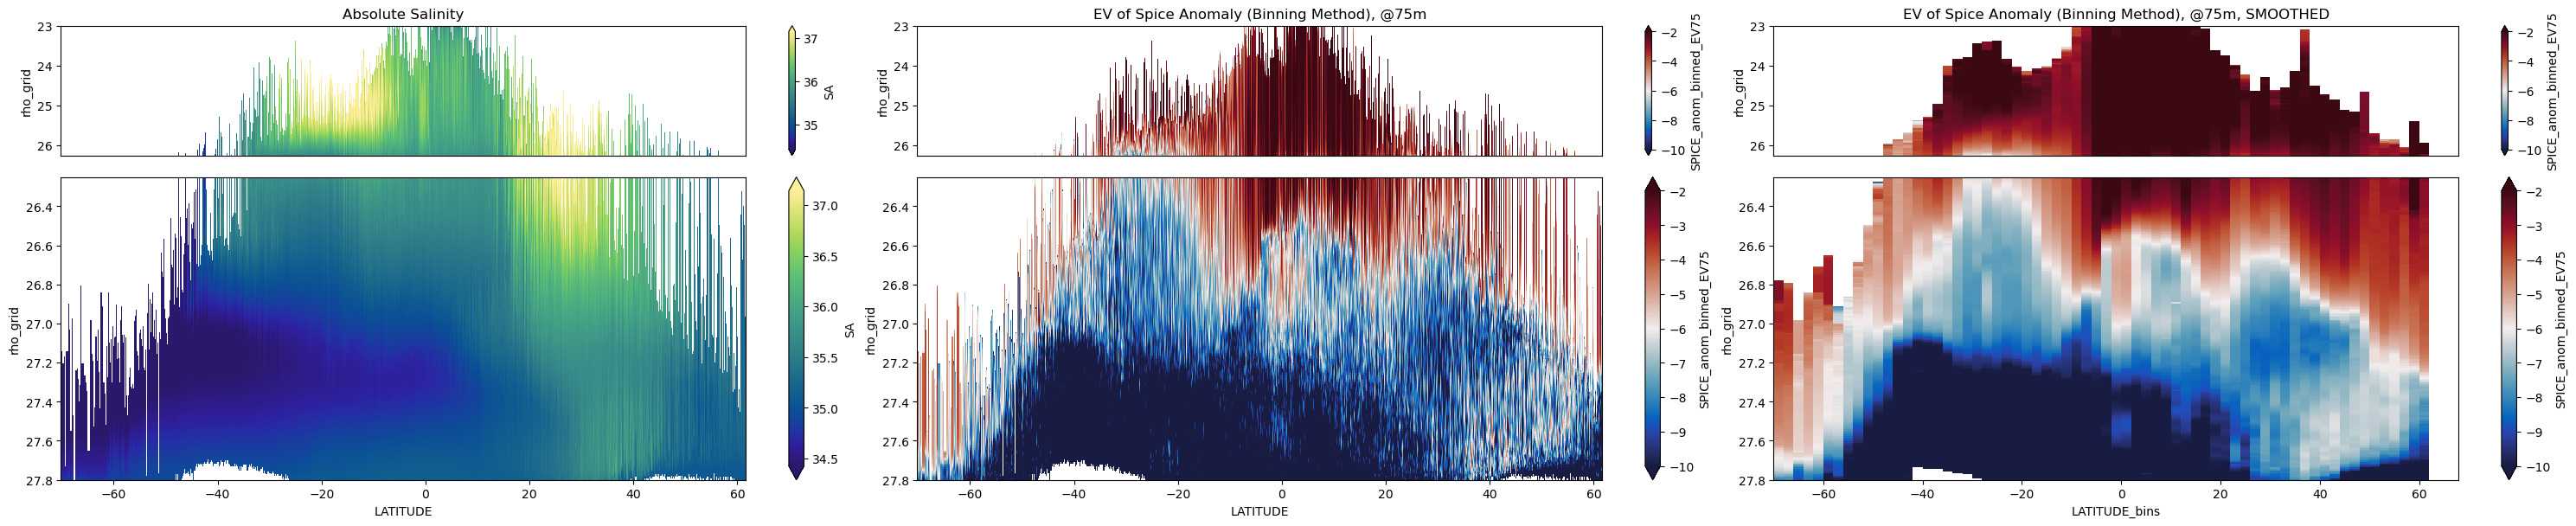

In [201]:
fig = plt.figure(figsize=(30,5))
top = 23
mid = 26.25
bot = 27.8

ax1 = fig.add_axes([0,0.75,0.33,0.3])
rho_atl.SA.sortby(x).plot(x=x,y='rho_grid',ax=ax1,cmap=cmo.haline,robust=True)
plt.gca().invert_yaxis()
ax1.set_ylim(mid,top)
ax1.set_xticks([])
ax1.set_xlabel('')
plt.title('Absolute Salinity')

ax2 = fig.add_axes([0,0,0.33,0.7])
rho_atl.SA.sortby(x).plot(x=x,y='rho_grid',ax=ax2,cmap=cmo.haline,robust=True)
plt.gca().invert_yaxis()
ax2.set_ylim(bot,mid)

ax3 = fig.add_axes([0.33,0.75,0.33,0.3])
np.log(rho_atl.SPICE_anom_binned_EV75).sortby(x).plot(x=x,y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax3.set_ylim(mid,top)
ax3.set_xticks([])
ax3.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m'.format(lfilter))

ax4 = fig.add_axes([0.33,0,0.33,0.7])
np.log(rho_atl.SPICE_anom_binned_EV75).sortby(x).plot(x=x,y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax4.set_ylim(bot,mid)

ax5 = fig.add_axes([0.66,0.75,0.33,0.3])
np.log(rho_atl.SPICE_anom_binned_EV75.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax5,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax5.set_ylim(mid,top)
ax5.set_xticks([])
ax5.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, SMOOTHED'.format(lfilter))

ax6 = fig.add_axes([0.66,0,0.33,0.7])
np.log(rho_atl.SPICE_anom_binned_EV75.groupby_bins('LATITUDE',lat_bins).mean('N_PROF_NEW')).plot(y='rho_grid',ax=ax6,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax6.set_ylim(bot,mid)

In [250]:
rho_atl_wint_NH = rho_atl.SPICE_anom_binned_EV75.where(rho_atl.LATITUDE>=0).where(rho_atl.TIME.dt.month <4).dropna(dim='N_PROF_NEW',how='all')
rho_atl_summ_SH = rho_atl.SPICE_anom_binned_EV75.where(rho_atl.LATITUDE<0).where(rho_atl.TIME.dt.month <4).dropna(dim='N_PROF_NEW',how='all')
rho_atl_summ_NH = rho_atl.SPICE_anom_binned_EV75.where(rho_atl.LATITUDE>=0).where(rho_atl.TIME.dt.month <10).where(rho_atl.TIME.dt.month >6).dropna(dim='N_PROF_NEW',how='all')
rho_atl_wint_SH = rho_atl.SPICE_anom_binned_EV75.where(rho_atl.LATITUDE<0).where(rho_atl.TIME.dt.month <10).where(rho_atl.TIME.dt.month >6).dropna(dim='N_PROF_NEW',how='all')
print('winter months: {} (NH), {} (SH), summer months: {} (NH), {} (SH)'.format(np.unique(rho_atl_wint_NH.TIME.dt.month.data),np.unique(rho_atl_wint_SH.TIME.dt.month.data),np.unique(rho_atl_summ_NH.TIME.dt.month.data),np.unique(rho_atl_summ_SH.TIME.dt.month.data)))

winter months: [1 2 3] (NH), [7 8 9] (SH), summer months: [7 8 9] (NH), [1 2 3] (SH)


(27.8, 26.25)

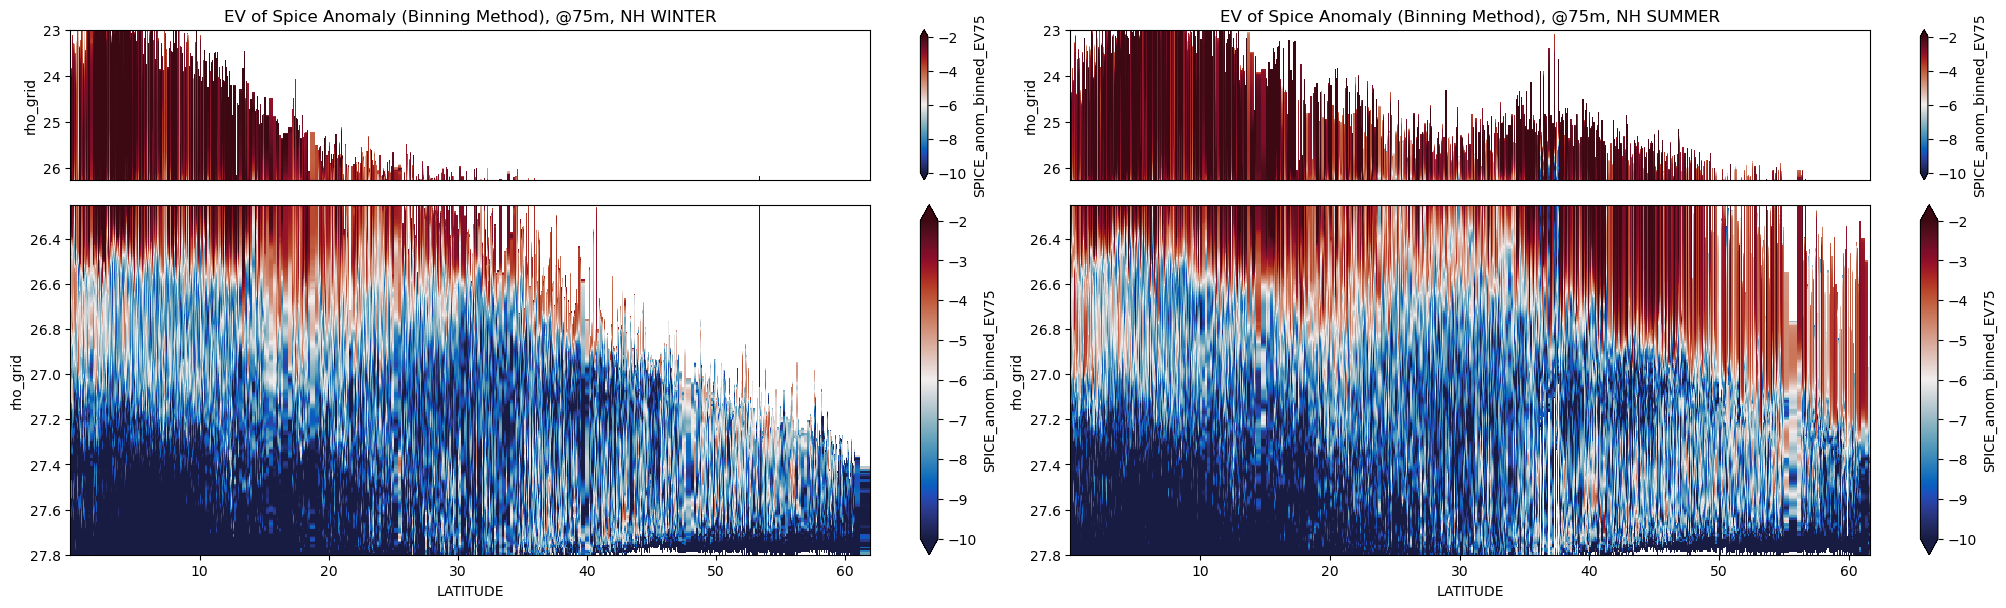

In [275]:
fig = plt.figure(figsize=(20,5))

top = 23
mid = 26.25
bot = 27.8

ax1 = fig.add_axes([0,0.75,0.5,0.3])
np.log(rho_atl_wint_NH.sortby(x)).plot(x=x,y='rho_grid',ax=ax1,cmap=cmo.balance,vmin=-10,vmax=-2)
#np.log(rho_atl_summ_SH.sortby(x)).plot(x=x,y='rho_grid',ax2=ax2,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax1.set_ylim(mid,top)
ax1.set_xticks([])
ax1.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, NH WINTER'.format(lfilter))

ax2 = fig.add_axes([0,0,0.5,0.7])
np.log(rho_atl_wint_NH.sortby(x)).plot(x=x,y='rho_grid',ax=ax2,cmap=cmo.balance,vmin=-10,vmax=-2)
#np.log(rho_atl_summ_SH.sortby(x)).plot(x=x,y='rho_grid',ax=ax2,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax2.set_ylim(bot,mid)

ax3 = fig.add_axes([0.5,0.75,0.5,0.3])
np.log(rho_atl_summ_NH.sortby(x)).plot(x=x,y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
#np.log(rho_atl_wint_SH.sortby(x)).plot(x=x,y='rho_grid',ax=ax3,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax3.set_ylim(mid,top)
ax3.set_xticks([])
ax3.set_xlabel('')
plt.title('EV of Spice Anomaly (Binning Method), @{}m, NH SUMMER'.format(lfilter))

ax4 = fig.add_axes([0.5,0,0.5,0.7])
np.log(rho_atl_summ_NH.sortby(x)).plot(x=x,y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
#np.log(rho_atl_wint_SH.sortby(x)).plot(x=x,y='rho_grid',ax=ax4,cmap=cmo.balance,vmin=-10,vmax=-2)
plt.gca().invert_yaxis()
ax4.set_ylim(bot,mid)